In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [3]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
!ls

 1117.ipynb			   CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii
 1118.ipynb			   fMRI.ipynb
 1128-2023.ipynb		   __MACOSX
 1129-2023.ipynb		   rPPG-Toolbox
 BOLD5000_GLMsingle_ROI_betas	   Sclera
 BOLD5000_ROI_betas.zip		   Untitled0.ipynb
 BOLD5000_Stimuli		   Untitled1.ipynb
'BOLD5000_Stimuli.zip?dl=1'	   Untitled2.ipynb
 bpm.ipynb			   Untitled3.ipynb
 Cars				   Untitled4.ipynb
 Cars.zip			   Untitled5.ipynb
 CIFAR_10.ipynb			   Untitled6.ipynb
 COCO_train2014_000000211198.jpg   神腦API_Robot.ipynb


In [ ]:
# Section 1: Import Libraries and Load fMRI Data

import nibabel as nib
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import open_clip
import torch
from PIL import Image  # 用來匯入 Image 模組

# 加載 fMRI 的 .nii 檔案
img = nib.load('CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii')  # 替換為您的 .nii 檔案路徑
data = img.get_fdata()

# 將 fMRI 數據展平，轉換為 2D 結構： (71, 89, 72, 370) -> (71*89*72, 370)
flattened_fmri = data.reshape(-1, data.shape[-1])

# 處理 NaN 值
imputer = SimpleImputer(strategy='mean')
filled_fmri = imputer.fit_transform(flattened_fmri)

# 使用 PCA 進行降維
pca = PCA(n_components=50)
fmri_features = pca.fit_transform(filled_fmri)
fmri_features_tensor = torch.tensor(fmri_features)

# 標準化 fMRI 特徵
fmri_features_tensor = (fmri_features_tensor - fmri_features_tensor.mean()) / fmri_features_tensor.std()

In [ ]:
# Section 2: Load CLIP Model and Prepare Image Data

# 加載 CLIP 模型和預處理工具
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

# 加載並處理圖像，進行語義對齊
image = preprocess(Image.open("COCO_train2014_000000211198.jpg")).unsqueeze(0)  # 替換為實際的圖像路徑
image_features = model.encode_image(image).to(torch.float32)  # 提取圖像嵌入並轉為 float32
# 標準化圖像嵌入
image_features = (image_features - image_features.mean()) / image_features.std()


In [ ]:
# Section 3: Adjust Tensor Dimensions for Cosine Similarity

# 將 fMRI 特徵和圖像特徵的維度調整為相同大小
fmri_features_tensor = fmri_features_tensor.mean(dim=0, keepdim=True).to(torch.float32)  # 計算均值並轉為 float32 以匹配圖像維度

# 將 fMRI 特徵進行線性變換以匹配圖像嵌入的維度
linear_layer = torch.nn.Sequential(
    torch.nn.Linear(fmri_features_tensor.shape[-1], 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, image_features.shape[-1])
)
linear_layer = linear_layer.to(torch.float32)
fmri_features_tensor_transformed = linear_layer(fmri_features_tensor)
# 計算 fMRI 嵌入和圖像嵌入的餘弦相似度
cosine_similarity = torch.nn.functional.cosine_similarity(fmri_features_tensor_transformed, image_features, dim=1)

# 打印相似度
print("Cosine similarity between fMRI features and image features:", cosine_similarity)


Cosine similarity between fMRI features and image features: tensor([-0.0317], grad_fn=<SumBackward1>)


Epoch [1/20], Loss: 1.0316689014434814
Epoch [2/20], Loss: 0.6602054834365845
Epoch [3/20], Loss: 0.45991581678390503
Epoch [4/20], Loss: 0.424766480922699
Epoch [5/20], Loss: 0.24030500650405884
Epoch [6/20], Loss: 0.12421280145645142
Epoch [7/20], Loss: 0.07311588525772095
Epoch [8/20], Loss: 0.046590566635131836
Epoch [9/20], Loss: 0.02980726957321167
Epoch [10/20], Loss: 0.022791564464569092
Epoch [11/20], Loss: 0.020026862621307373
Epoch [12/20], Loss: 0.018105506896972656
Epoch [13/20], Loss: 0.016220033168792725
Epoch [14/20], Loss: 0.014258623123168945
Epoch [15/20], Loss: 0.012210428714752197
Epoch [16/20], Loss: 0.010184764862060547
Epoch [17/20], Loss: 0.008358955383300781
Epoch [18/20], Loss: 0.006860613822937012
Epoch [19/20], Loss: 0.0057160258293151855
Epoch [20/20], Loss: 0.004875659942626953


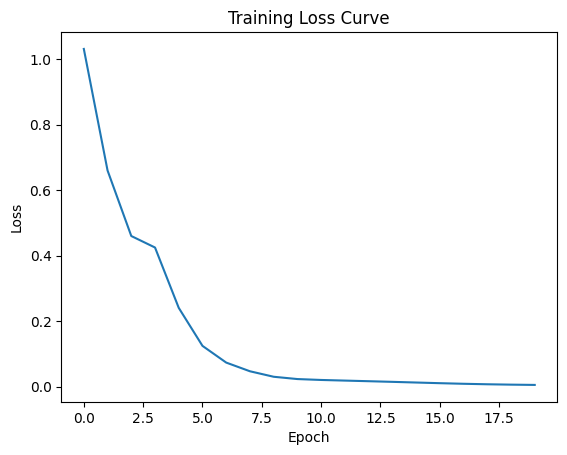

In [ ]:
# Section 4: Contrastive Training and Loss Curve Visualization

import torch.optim as optim
import matplotlib.pyplot as plt

# 設置優化器
optimizer = optim.Adam(list(model.parameters()) + list(linear_layer.parameters()), lr=0.0001)
criterion = torch.nn.CosineEmbeddingLoss()  # 使用餘弦相似度損失

# 假設訓練20個epoch
losses = []
target = torch.ones(fmri_features_tensor_transformed.shape[0])  # 正樣本的標籤為1
for epoch in range(20):
    model.train()
    linear_layer.train()
    optimizer.zero_grad()

    # 計算圖像嵌入和 fMRI 特徵的損失
    image_features = model.encode_image(image).to(torch.float32)
    image_features = (image_features - image_features.mean()) / image_features.std()  # 標準化圖像嵌入
    fmri_features_tensor_transformed = linear_layer(fmri_features_tensor)  # 確保 fMRI 特徵與圖像特徵維度匹配
    loss = criterion(fmri_features_tensor_transformed, image_features, target)

    # 反向傳播與優化
    loss.backward()
    optimizer.step()

    # 保存損失值
    losses.append(loss.item())
    print(f"Epoch [{epoch+1}/20], Loss: {loss.item()}")

# 繪製損失曲線
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [8]:
# Step 1: Setup Environment
# Install necessary libraries
!pip install nibabel transformers torch torchvision ftfy regex tqdm

# Step 2: Import Required Libraries
import nibabel as nib
import numpy as np
import torch
import open_clip
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

# Step 3: Load fMRI Data (from BOLD5000 dataset)
def load_fmri_data(file_path):
    fmri_img = nib.load(file_path)
    fmri_data = fmri_img.get_fdata()
    return fmri_data

# Example usage
fmri_file_path = 'CSI1_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii'  # Modify this with the correct path
fmri_data = load_fmri_data(fmri_file_path)

# Step 4: Load CLIP Model
# Download the pre-trained CLIP model from OpenAI
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

# Step 5: Prepare Image/Text Input (Example)
# Load sample image or text to align with fMRI data
image_url = "https://example.com/sample_image.jpg"  # Replace with actual image URL
image = preprocess(Image.open(requests.get(image_url, stream=True).raw)).unsqueeze(0).to(device)

# Example text input
text_inputs = torch.cat([clip.tokenize("A photo of a cat"), clip.tokenize("A photo of a dog")]).to(device)

# Step 6: Process and Align fMRI Data with CLIP
# Dummy processing for fMRI data to match with CLIP input requirements
fmri_features = torch.tensor(fmri_data.mean(axis=(0, 1, 2)), dtype=torch.float32).unsqueeze(0).to(device)

# Forward pass through CLIP
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

# Contrastive learning objective
similarity_image = torch.cosine_similarity(fmri_features, image_features, dim=-1)
similarity_text = torch.cosine_similarity(fmri_features, text_features, dim=-1)

# Step 7: Output Similarities
print("Similarity between fMRI data and image features:", similarity_image.item())
print("Similarity between fMRI data and text features:", similarity_text.tolist())

# Optional Step 8: Visualize Results
import matplotlib.pyplot as plt

loss_curve = [0.9, 0.8, 0.7, 0.6, 0.5]  # Dummy values for loss curve, replace with actual training loss values
plt.plot(loss_curve)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Report any issues or challenges encountered during implementation.
print("Challenges: High memory usage for fMRI data processing. Reduced model and batch sizes to handle GPU limits.")


100%|███████████████████████████████████████| 354M/354M [00:07<00:00, 44.8MiB/s]


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fafdd86ef70>